# Numpy Reader

This reader operator reads from a directory or list of NumPy (npy) files. It extracts shape and datatype information directly from the files. Please note that the reader is currently only compatible with NumPy v1 and not v2 files. Note that v1 files are most commonly used (compare the [npy file format white page](https://numpy.org/neps/nep-0001-npy-format.html) for more information).

The `DALI_EXTRA_PATH` environment variable should point to the location where data from DALI extra repository is downloaded. We are working with the 3D MRI data from this repo.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [11]:
# DALI
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types

# misc python stuff
import numpy as np
import os.path
from glob import glob
import shutil
import tempfile

# visualization
from PIL import Image
import matplotlib.pyplot as plt

test_data_root = os.environ['DALI_EXTRA_PATH']
file_jpeg_root = os.path.join(test_data_root, 'db', '3D', 'MRI', 'Knee', 'Jpegs', 'STU00001')
file_numpy_root = tempfile.mkdtemp()
batch_size = 4

Next we load the image data and convert it to numpy:

In [12]:
file_dirs = os.listdir(file_jpeg_root)
for file_dir in file_dirs:
    
    # prepare temporary output directory
    os.makedirs(os.path.join(file_numpy_root, file_dir), exist_ok = True)

    # load files and convert to numpy
    current_dir = os.path.join(file_jpeg_root, file_dir)
    for file in glob(os.path.join(current_dir, "*.jpg")):
        with Image.open(os.path.join(current_dir, file)) as im:
            arr = np.asarray(im)
            outfile = os.path.join(file_numpy_root, file_dir, os.path.basename(file).replace("jpg", "npy"))
            np.save(outfile, arr)

In [13]:
pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
with pipe:
    data = fn.readers.numpy(device = "cpu",
                            file_root = file_numpy_root,
                            cache_header_information = True)
    pipe.set_outputs(data)

In [14]:
pipe.build()
pipe_out = pipe.run()                                                

data_cpu = pipe_out[0].as_array()

The operator returns the array as it was described in the file. If the file is in FOTRAN (column-major) order, the resulting numpy array in memory will be in C (row-major) order as the reader will automatically transpose data to that order.

We can visualize the first batch to check if it was loaded correctly:

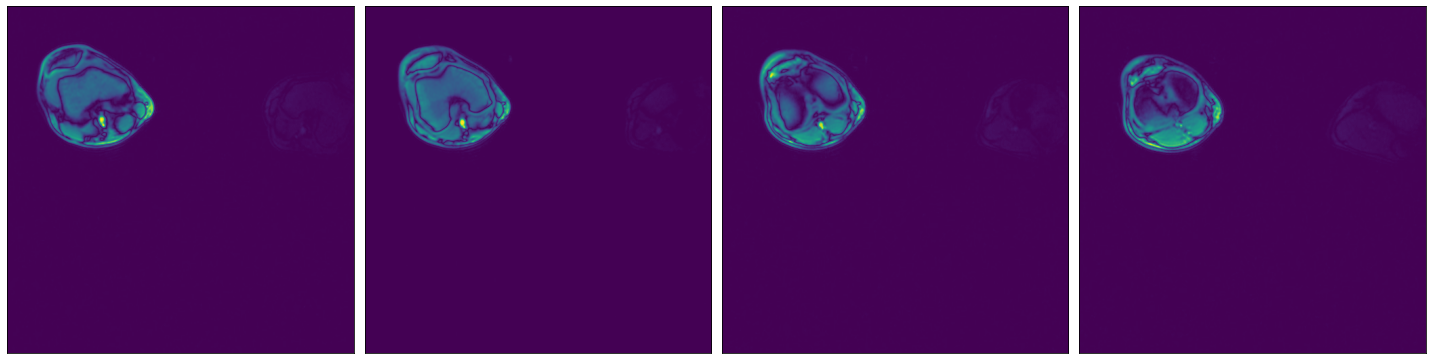

In [25]:
def plot_batch(batch_cpu):
    fig, axvec = plt.subplots(nrows = 1, ncols = batch_size, figsize=(20, 20*batch_size))
    for i in range(batch_size):
        ax = axvec[i]
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.imshow(Image.fromarray(batch_cpu[i]))
    plt.tight_layout()
    
plot_batch(data_cpu)

## Reading slices

We see that the relevant data is concentrated in the upper left quadrant of the image and the rest does not contain useful information (please not that this is not true for all of the images from the dataset, but we are focusing on those 4 for illustrative purposes).

In order to get rid of the uninformative region, we can apply image cropping. 
The numpy reader supports reading slices from files, and thus can perform cropping in an efficient way. For a full list of options visit the [documentation](https://docs.nvidia.com/deeplearning/dali/main-user-guide/docs/supported_ops.html?highlight=numpy#nvidia.dali.fn.readers.numpy). In this example, we read a constant slice from the input dataset.

First, we define region of interest (ROI) bounds:

In [26]:
roi_start = [0, 0]
roi_end = [256, 256]

Now we can create a new pipeline with these slicing parameters:

In [31]:
pipe_sliced = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
with pipe_sliced:
    data = fn.readers.numpy(device = "cpu",
                            file_root = file_numpy_root,
                            cache_header_information = True,
                            roi_start = roi_start,
                            roi_end = roi_end)
    pipe_sliced.set_outputs(data)

Now we can execute the pipe and check the shape of the resulting array:

In [32]:
pipe_sliced.build()
pipe_out = pipe_sliced.run()                                                

data_sliced_cpu = pipe_out[0].as_array()

Which is, up to batch size, exactly `roi_end - roi_start` as expected. We can again visualize the images:

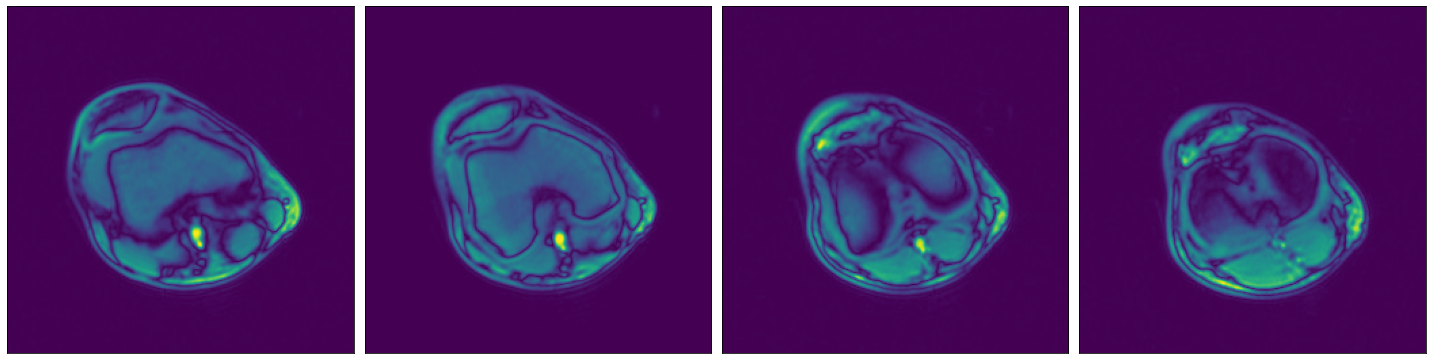

In [33]:
plot_batch(data_sliced_cpu)

Note that currently, a performance benefit in using sliced reads over the separate operations of reading + slicing is only seen when mmap is used. If mmap is disabled, the file will be read completely before it will be sliced.

## GPUDirect Storage Support

Note that DALI numpy reader supports [GPUDirect Storage (GDS)](https://developer.nvidia.com/gpudirect-storage) via libfucile. 

In order to enable GDS support in DALI, make sure GDS is installed. On Systems with CUDA 11.4 or newer, GDS is already installed as part of the CUDA 11.4 SDK. For older CUDA releases, please install GDS separately (follow the link above for instructions).

Once GDS is installed, it can be used by simply switching the device of the reader to `"gpu"`, i.e.:

In [ ]:
pipe_gds = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
with pipe_gds:
    data = fn.readers.numpy(device = "gpu",
                            file_root = file_data_root,
                            cache_header_information = True)
    pipe_gds.set_outputs(data)
    
pipe_gds.build()
pipe_out = pipe_gds.run()                                                

data_cpu = pipe_out[0].as_array()
print(data_cpu.shape)

Note that if GDS is not available, you will likely see a CUDA Driver API error when trying to execute the pipeline.

We clean up the temporary files below

In [ ]:
shutil.rmtree(file_data_root)